In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#%pip install tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [3]:
device_name = tf.test.gpu_device_name()

In [4]:
#model_save_path = '/content/drive/MyDrive/Telecom Paris/projet robotique mobile/Project/data/keypoint_classifier.keras'
model_save_path = '/content/drive/MyDrive/Telecom Paris/projet robotique mobile/Project/data/keypoint_classifier_merge.keras'
CSV_PATH = '/content/drive/MyDrive/Telecom Paris/projet robotique mobile/Project/data/keypoint_merged.csv'

In [5]:
RANDOM_SEED = 42
NUM_KEYPOINTS = 21

In [6]:
df = pd.read_csv(CSV_PATH, header=None)

print(f"Shape du dataset : {df.shape}")
print(f"Nombre de colonnes attendues : {1 + NUM_KEYPOINTS * 2} (label + 21 x,y)")
assert df.shape[1] == 1 + NUM_KEYPOINTS * 2, "Format incorrect de keypoint.csv"

Shape du dataset : (9024, 43)
Nombre de colonnes attendues : 43 (label + 21 x,y)


In [8]:
labels = df.iloc[:, 0].values
features = df.iloc[:, 1:].values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.75, random_state=RANDOM_SEED)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([1595, 1663, 1510,  672,  164,  257,  139,  190, 2110,  724]))


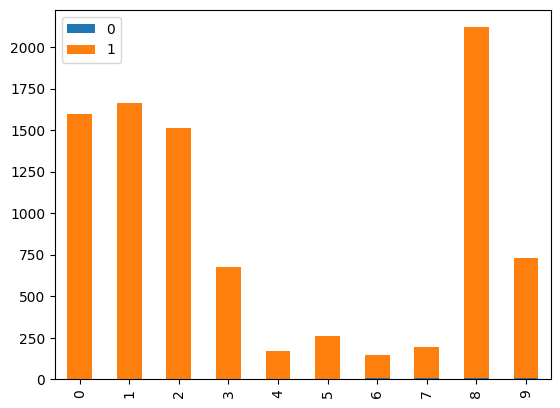

In [10]:
counts = np.unique(labels, return_counts=True)
df = pd.DataFrame(counts)
df.T.plot(kind="bar", stacked=True)
print(counts)

In [11]:
class KeypointGestureClassifier:
    def __init__(self, X_train, y_train, X_test, y_test, model_save_path, num_class= 8, batch_size=32):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.model_save_path = model_save_path
        self.num_classes = num_class
        self.model = self.build_model()
        self.batch_size = batch_size
        # os.makedirs(os.path.dirname(self.model_save_path), exist_ok=True) ## a quoi ça sert ?

    def build_model(self):
        return tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(self.X_train.shape[1],)),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(self.num_classes, activation='softmax')
        ])

    def compile_model(self):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='sparse_categorical_crossentropy', # sinon il faut one_encode les labels 'categorical_crossentropy',
            metrics=['accuracy']
        )

    def create_callbacks(self, patience=50):
        cp_callback = tf.keras.callbacks.ModelCheckpoint(
            self.model_save_path,
            save_best_only=True,
            save_weights_only=False,
            verbose=1
        )
        es_callback = tf.keras.callbacks.EarlyStopping(
            patience=patience,
            restore_best_weights=True,
            verbose=1
        )
        return [cp_callback, es_callback]

    def train(self, epochs=1000, callbacks=None):
        if callbacks is None:
            callbacks = self.create_callbacks()
        history = self.model.fit(
                self.X_train,
                self.y_train,
                epochs=epochs,
                batch_size=self.batch_size,
                validation_data=(self.X_test, self.y_test),
                callbacks=callbacks
        )
        return history

    def evaluate_saved_model(self):
        model = tf.keras.models.load_model(self.model_save_path)
        loss, acc = model.evaluate(self.X_test, self.y_test, batch_size=64)
        print(f"Test: accuracy is {acc:.4f} and loss is {loss:.4f}")
        return model

    def predict(self, input_array):
        if self.model is None:
            self.model = tf.keras.models.load_model(self.model_save_path)
        preds = self.model.predict(np.array([input_array]))
        return preds[0]  # vecteur de probabilités


In [12]:
KeypointGestureModel = KeypointGestureClassifier(X_train, y_train, X_test, y_test, model_save_path, num_class= 10, batch_size=32)

In [13]:
KeypointGestureModel.compile_model()

In [14]:
KeypointGestureModel.train()

Epoch 1/1000
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3481 - loss: 1.7799
Epoch 1: val_loss improved from inf to 0.58858, saving model to /content/drive/MyDrive/Telecom Paris/projet robotique mobile/Project/data/keypoint_classifier_merge.keras
212/212 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.3489 - loss: 1.7779 - val_accuracy: 0.7992 - val_loss: 0.5886
Epoch 2/1000
197/212 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7583 - loss: 0.6587
Epoch 2: val_loss improved from 0.58858 to 0.33366, saving model to /content/drive/MyDrive/Telecom Paris/projet robotique mobile/Project/data/keypoint_classifier_merge.keras
212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7604 - loss: 0.6530 - val_accuracy: 0.8839 - val_loss: 0.3337
Epoch 3/1000
198/212 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8433 - loss: 0.4429
Epoch 3: val_loss improved from 0.33366 to 0.22001, saving model to /content/drive/MyDrive/Telecom Paris/projet robotique mobile/Project/data/keypoint_classi

In [15]:
KeypointGestureModel.evaluate_saved_model()

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9958 - loss: 0.0083
Test: accuracy is 0.9969 and loss is 0.0067


<Sequential name=sequential, built=True>

In [16]:
prediction = KeypointGestureModel.predict(X_test[0])
np.argmax(np.squeeze(prediction))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


np.int64(1)

In [17]:
model = tf.keras.models.load_model(model_save_path)

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


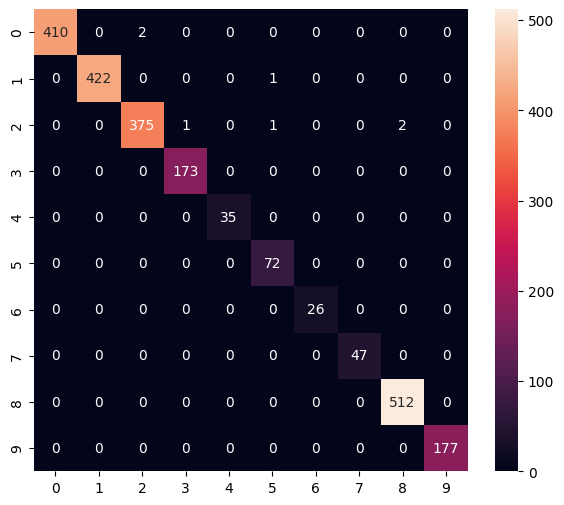

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       412
           1       1.00      1.00      1.00       423
           2       0.99      0.99      0.99       379
           3       0.99      1.00      1.00       173
           4       1.00      1.00      1.00        35
           5       0.97      1.00      0.99        72
           6       1.00      1.00      1.00        26
           7       1.00      1.00      1.00        47
           8       1.00      1.00      1.00       512
           9       1.00      1.00      1.00       177

    accuracy                           1.00      2256
   macro avg       1.00      1.00      1.00      2256
weighted avg       1.00      1.00      1.00      2256



In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()

    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)